In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/BA820 Project/merged_data1.parquet')
print(df.head())

                 user_id                 name_x           time  rating  \
0  116404531305033742641  Zygintas Krasodomskis  1568240961087     5.0   
1  101806853201406057266            Olga Harbar  1590701094969     3.0   
2  110623621391484838669             Amit Patel  1558575636156     4.0   
3  114893265310260912873         Jerry Cardillo  1535435901765     4.0   
4  106080008682473967828           Jake Moreira  1487952273508     4.0   

                                                text  resp  \
0                     Honestly, best burgers in town  None   
1                                               None  None   
2                                               None  None   
3                                               None  None   
4  This place gave me a good sanwich and a fry bu...  None   

                                 gmap_id                 name_y  \
0  0x89e37a19e56a4565:0xbb2aefc495e8c505              Five Guys   
1  0x89e45acc1861f709:0x9ccc502a907ff195  Price 

In [ ]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,391626
resp,756452
gmap_id,0
name_y,0
address,0
latitude,0


In [ ]:
df['text'] = df['text'].fillna("N/A")
df['resp'] = df['resp'].fillna("N/A")

In [ ]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,0
resp,0
gmap_id,0
name_y,0
address,0
latitude,0


In [ ]:
numerical_cols = ['rating', 'avg_rating', 'num_of_reviews']
categorical_cols = ['category']
text_cols = ['text', 'resp']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

num_df = pd.DataFrame(num_scaled, columns=[f"num_feature_{i}" for i in range(num_scaled.shape[1])])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df[categorical_cols])

# Convert to DataFrame with proper column names
category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_resp = TfidfVectorizer(stop_words='english', max_features=50)

text_transformed = vectorizer_text.fit_transform(df['text'])
resp_transformed = vectorizer_resp.fit_transform(df['resp'])

# Convert to DataFrame
text_df = pd.DataFrame(text_transformed.toarray(), columns=[f"text_{col}" for col in vectorizer_text.get_feature_names_out()])
resp_df = pd.DataFrame(resp_transformed.toarray(), columns=[f"resp_{col}" for col in vectorizer_resp.get_feature_names_out()])

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

final_df = pd.concat([num_df, category_df, text_df, resp_df], axis=1)

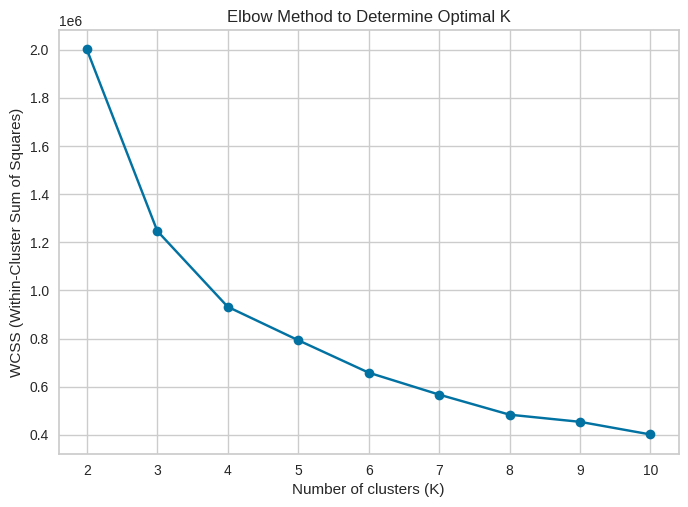

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(num_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method to Determine Optimal K')
plt.show()



In [ ]:
from sklearn.cluster import KMeans

optimal_k = 3

if 'cluster' in num_df.columns:
    num_df = num_df.drop(columns=['cluster'])

X = num_df.select_dtypes(include=['number'])

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, init='k-means++')
num_df['cluster'] = kmeans.fit_predict(X)

print(num_df['cluster'].unique())
print(num_df['cluster'].value_counts())

[0 2 1]
cluster
0    676214
2    152785
1     32493
Name: count, dtype: int64


**Cluster Distribution:**
* Cluster 0 (Normal Businesses): 676,214 businesses – likely represents the majority of typical businesses.
* Cluster 2 (Moderate Variation): 152,785 businesses – may indicate a slightly different pattern in customer engagement.
* Cluster 1 (Highly Suspicious Group): Only 32493 businesses – these businesses might be fraudulent or have manipulated reviews.


##Investigate Anomalous Clusters

In [ ]:
suspicious_businesses = num_df[num_df['cluster'] == 1]
print(suspicious_businesses.describe())

       num_feature_0  num_feature_1  num_feature_2  cluster
count   32493.000000   32493.000000   32493.000000  32493.0
mean        0.159700       0.300794       4.136306      1.0
std         0.721552       0.637977       1.653561      0.0
min        -2.891104      -1.571443       1.961905      1.0
25%        -0.267397      -0.027078       2.608377      1.0
50%         0.607172       0.487711       3.859297      1.0
75%         0.607172       0.745105       6.392655      1.0
max         0.607172       1.259893       6.392655      1.0


##Silouette

In [ ]:
from sklearn.metrics import silhouette_score

X_sampled = num_df.drop(columns=['cluster']).sample(frac=0.1, random_state=42)

silhouette_scores = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_sampled)
    score = silhouette_score(X_sampled, cluster_labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")


K=2, Silhouette Score=0.4525
K=3, Silhouette Score=0.4999
K=4, Silhouette Score=0.3665
K=5, Silhouette Score=0.3558


##Visualization

In [ ]:
print(num_df['cluster'].unique())

[0 2 1]


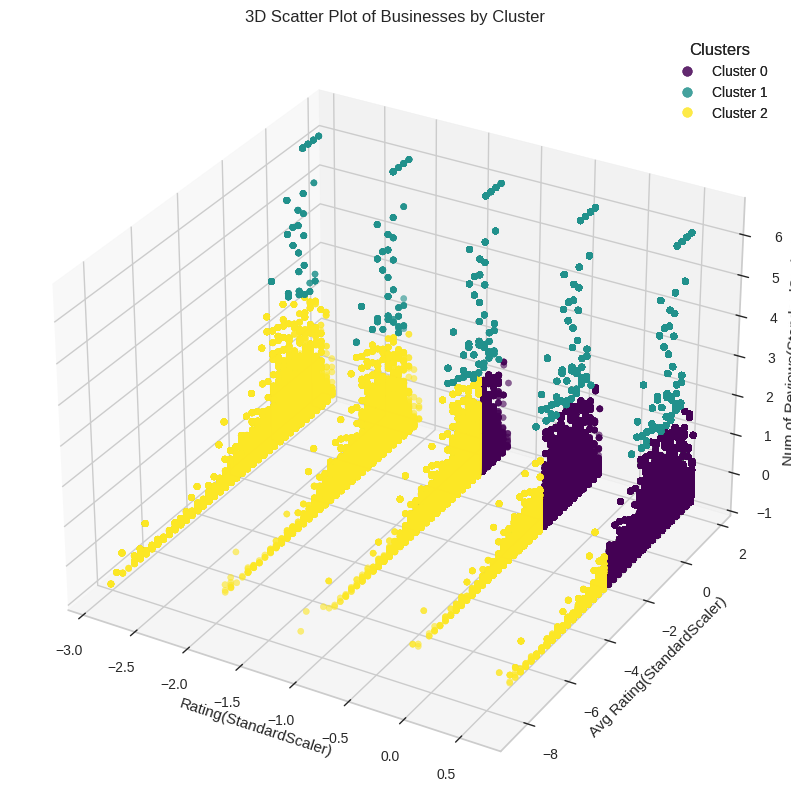

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    num_df['num_feature_0'],
    num_df['num_feature_1'],
    num_df['num_feature_2'],
    c=num_df['cluster'],
    cmap='viridis',
    alpha=0.6
)

ax.set_xlabel('Rating(StandardScaler)')
ax.set_ylabel('Avg Rating(StandardScaler)')
ax.set_zlabel('Num of Reviews(StandardScaler)')
ax.set_title('3D Scatter Plot of Businesses by Cluster')

handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend1 = ax.legend(handles, ['Cluster 0', 'Cluster 1', 'Cluster 2'], title="Clusters")
ax.add_artist(legend1)

plt.show()

##Conlusion and Recommendation:

Our K-Means clustering analysis successfully grouped businesses based on customer reviews, ratings, and metadata, uncovering distinct behavioral patterns in the marketplace. One of the most striking findings was the emergence of a highly suspicious business cluster—a small group of businesses exhibiting unusual rating distributions, sudden review spikes, and potentially manipulated feedback.

There are also some real-life applications:

*   Fraud Detection in Online Marketplaces

  Platforms like Google Reviews, Yelp, and Amazon rely heavily on customer feedback. Our findings demonstrate how K-Means clustering can help flag businesses with artificial rating patterns, enabling platforms to take proactive measures against fraudulent activities.

*   Business Reputation Management

  Legitimate businesses can use clustering insights to identify customer sentiment trends, compare their performance with competitors, and make data-driven improvements to service quality and customer experience.

*   Consumer Protection & Trust Building

  Regulators and consumer advocacy groups can leverage clustering techniques to spot deceptive practices and ensure a fair digital marketplace. Highlighting clusters of suspicious businesses allows for better policy enforcement and consumer awareness.
